In [1]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_squared_log_error
from sklearn.ensemble import RandomForestRegressor
from lightgbm import LGBMRegressor

In [2]:
%matplotlib inline

In [3]:
df_sales = pd.read_csv('Sales_Transactions_Dataset_Weekly.csv')
df_sales = df_sales.filter(regex=r'Product|W')

In [4]:
df_sales.head()

,Product_Code,W0,W1,W2,W3,W4,W5,W6,W7,W8,...,W42,W43,W44,W45,W46,W47,W48,W49,W50,W51
0,P1,11,12,10,8,13,12,14,21,6,...,4,7,8,10,12,3,7,6,5,10
1,P2,7,6,3,2,7,1,6,3,3,...,2,4,5,1,1,4,5,1,6,0
2,P3,7,11,8,9,10,8,7,13,12,...,6,14,5,5,7,8,14,8,8,7
3,P4,12,8,13,5,9,6,9,13,13,...,9,10,3,4,6,8,14,8,7,8
4,P5,8,5,13,11,6,7,9,14,9,...,7,11,7,12,6,6,5,11,8,9


In [5]:
# Transform the data
df_melt = df_sales.melt(id_vars='Product_Code', var_name='Week', value_name='Sales')

# Rename the values in Product_Code and 'Week'
df_melt['Product_Code'] = df_melt['Product_Code'].str.extract('(\d+)', expand=False).astype(int)
df_melt['Week'] = df_melt['Week'].str.extract('(\d+)', expand=False).astype(int)

# New dataframe with melt
df_melt = df_melt.sort_values(['Week', 'Product_Code'])
df_melt.head()

,Product_Code,Week,Sales
0,1,0,11
1,2,0,7
2,3,0,7
3,4,0,12
4,5,0,8


In [6]:
# Add Last_Week_Sales and Last_Week_Diff
df_melt['Last_Week_Sales'] = df_melt.groupby(['Product_Code'])['Sales'].shift()
df_melt['Last_Week_Diff'] = df_melt.groupby(['Product_Code'])['Last_Week_Sales'].diff()
df_melt = df_melt.dropna()
df_melt.head()

,Product_Code,Week,Sales,Last_Week_Sales,Last_Week_Diff
1622,1,2,10,12.0,1.0
1623,2,2,3,6.0,-1.0
1624,3,2,8,11.0,4.0
1625,4,2,13,8.0,-4.0
1626,5,2,13,5.0,-3.0


In [7]:
# Function - Error Rate
def error_rate(ytrue, yprod):
    return np.sqrt(mean_squared_log_error(ytrue, yprod))

mean_error = []
for week in range(40, 52):
    df_train = df_melt[df_melt['Week'] < week]
    df_target = df_melt[df_melt['Week'] == week]
    
    error = error_rate(df_target['Sales'].values, df_target['Last_Week_Sales'].values)
    print('Week:', str(week), ' - Error:', str(error))
    mean_error.append(error)
    
print('Mean Error:', np.mean(mean_error))
    

Week: 40  - Error: 0.5195223738554612
Week: 41  - Error: 0.5169135411741825
Week: 42  - Error: 0.5102635792859339
Week: 43  - Error: 0.5079204595063594
Week: 44  - Error: 0.5340885312370197
Week: 45  - Error: 0.5234709783234434
Week: 46  - Error: 0.5001778165328664
Week: 47  - Error: 0.49138005062262924
Week: 48  - Error: 0.5058450575478507
Week: 49  - Error: 0.5054683594189949
Week: 50  - Error: 0.5222037522547665
Week: 51  - Error: 0.5524234818116678
Mean Error: 0.5158064984642646


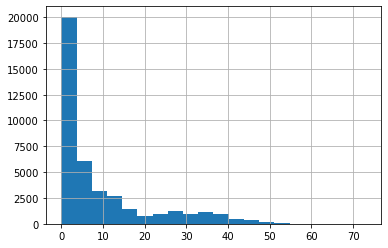

In [8]:
df_melt['Sales'].hist(bins=20);

In [9]:
mean_error = []
for week in range(40, 52):
    df_train = df_melt[df_melt['Week'] < week]
    df_target = df_melt[df_melt['Week'] == week]
    
    x_train = df_train.drop(['Sales'], axis=1)
    y_train = df_train['Sales'].values
    
    x_test = df_target.drop(['Sales'], axis=1)
    y_test = df_target['Sales'].values
    
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(x_train, y_train)
    
    predictions = model.predict(x_test)
    
    error = error_rate(y_test, predictions)
    print('Week:', str(week), ' - Error:', str(error))
    mean_error.append(error)
    
print('Mean Error:', np.mean(mean_error))

Week: 40  - Error: 0.4624228815973497
Week: 41  - Error: 0.45964344543639335
Week: 42  - Error: 0.4616574154939575
Week: 43  - Error: 0.4665509487966514
Week: 44  - Error: 0.4712160971026464
Week: 45  - Error: 0.4310019206106876
Week: 46  - Error: 0.4718253913330195
Week: 47  - Error: 0.44944566588632234
Week: 48  - Error: 0.46080164680769486
Week: 49  - Error: 0.4469557666483607
Week: 50  - Error: 0.4746450264363304
Week: 51  - Error: 0.48651316740461864
Mean Error: 0.4618899477961693


In [10]:
df_melt['Last_Week_Sales'] = df_melt.groupby(['Product_Code'])['Sales'].shift()
df_melt['Last_Week_Diff'] = df_melt.groupby(['Product_Code'])['Last_Week_Sales'].diff()
df_melt['Last-1_Week_Sales'] = df_melt.groupby(['Product_Code'])['Sales'].shift(2)
df_melt['Last-1_Week_Diff'] = df_melt.groupby(['Product_Code'])['Last-1_Week_Sales'].diff()
df_melt['Last-2_Week_Sales'] = df_melt.groupby(['Product_Code'])['Sales'].shift(3)
df_melt['Last-2_Week_Diff'] = df_melt.groupby(['Product_Code'])['Last-2_Week_Sales'].diff()
df_melt = df_melt.dropna()

In [11]:
mean_error = []
for week in range(40, 52):
    df_train = df_melt[df_melt['Week'] < week]
    df_target = df_melt[df_melt['Week'] == week]
    
    x_train = df_train.drop(['Sales'], axis=1)
    y_train = df_train['Sales'].values
    
    x_test = df_target.drop(['Sales'], axis=1)
    y_test = df_target['Sales'].values
    
    model = RandomForestRegressor(n_estimators=1000, n_jobs=-1, random_state=0)
    model.fit(x_train, y_train)
    
    predictions = model.predict(x_test)
    
    error = error_rate(y_test, predictions)
    print('Week:', str(week), ' - Error:', str(error))
    mean_error.append(error)
    
print('Mean Error:', np.mean(mean_error))

Week: 40  - Error: 0.43113376487841865
Week: 41  - Error: 0.4399411890647744
Week: 42  - Error: 0.42761939500524504
Week: 43  - Error: 0.4191339920561899
Week: 44  - Error: 0.4463686610715649
Week: 45  - Error: 0.40607179798095405
Week: 46  - Error: 0.4393699535116859
Week: 47  - Error: 0.43312518375936737
Week: 48  - Error: 0.4379376196741248
Week: 49  - Error: 0.4320075029409598
Week: 50  - Error: 0.4584577793639658
Week: 51  - Error: 0.4541855569775286
Mean Error: 0.4354460330237316
